#### Denoising Autoencoder

Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

Let's get started by importing our libraries and getting the dataset.

In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
from pathlib import Path
import sys
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
# from helpers import get_data_loaders
# from helpers import seed_all
# from helpers import anomaly_detection_display
import pandas as pd


np.random.seed(42)  

project_root_path = str(Path.cwd().parent)

if project_root_path not in sys.path:
    sys.path.insert(0, project_root_path)
    print(f"Added to sys.path: {project_root_path}")

from src.data import get_data_loaders

Added to sys.path: /Users/chaklader/Documents/Education/Udacity/Deep_Learning/Projects/2_landmark-classification-cnn


In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=20)

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


### Visualize the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7458944..1.9868248].


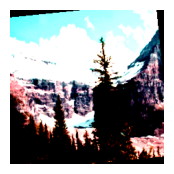

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)

# Convert to numpy and select first image
img = images[0].numpy()  # Convert PyTorch tensor to NumPy array
img = img.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

# If the image is normalized, you might need to denormalize it
# img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
# img = np.clip(img, 0, 1)

# Plot the image
fig, sub = plt.subplots(figsize=(2, 2)) 
sub.imshow(img)
sub.axis("off")

plt.show()


---

#### Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practice. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets.

---


---

#### Convolutional Denoising Autoencoder Architecture

A convolutional denoising autoencoder is a specialized neural network designed to remove noise from images while preserving important visual features. Unlike standard autoencoders that focus on compression and reconstruction, denoising autoencoders are specifically trained to clean corrupted images by learning to separate signal from noise.

The fundamental principle involves training the network with noisy images as input and clean images as targets, forcing the model to learn robust feature representations that distinguish between meaningful image content and unwanted noise artifacts.

##### Architecture Overview

This implementation features a deep convolutional autoencoder with a symmetric encoder-decoder structure designed for RGB images of size $224 \times 224$. The architecture progressively compresses spatial information while expanding feature channels, then reverses this process to reconstruct clean images.

```mermaid
flowchart TD
    Input["Input RGB Image<br>3×224×224"] --> E1["Encoder Block 1<br>32×112×112"]
    E1 --> E2["Encoder Block 2<br>64×56×56"]
    E2 --> E3["Encoder Block 3<br>128×28×28"]
    E3 --> E4["Encoder Block 4<br>256×14×14"]
    E4 --> E5["Bottleneck<br>512×7×7"]
    
    E5 --> D1["Decoder Block 1<br>256×14×14"]
    D1 --> D2["Decoder Block 2<br>128×28×28"]
    D2 --> D3["Decoder Block 3<br>64×56×56"]
    D3 --> D4["Decoder Block 4<br>32×112×112"]
    D4 --> D5["Decoder Block 5<br>16×224×224"]
    D5 --> Output["Output RGB Image<br>3×224×224"]
    
    style Input fill:#E8F4FD,color:#000
    style E1 fill:#D1E7FB,color:#000
    style E2 fill:#A3CCF6,color:#000
    style E3 fill:#75B1F1,color:#000
    style E4 fill:#4796EC,color:#000
    style E5 fill:#FFE0E0,color:#000
    style D1 fill:#FFE0CC,color:#000
    style D2 fill:#FFCC99,color:#000
    style D3 fill:#FFB366,color:#000
    style D4 fill:#FF9933,color:#000
    style D5 fill:#FF8000,color:#000
    style Output fill:#E0F0E0,color:#000
```

##### Encoder Architecture: Compression Path

The encoder systematically reduces spatial dimensions while increasing channel depth, creating a hierarchical representation of image features at multiple scales.

**Encoder Block Pattern:**
Each encoder block follows the same architectural pattern:
1. **Convolution**: $\text{Conv2d}(3 \times 3, \text{padding}=1)$ preserves spatial dimensions
2. **Activation**: $\text{ReLU}$ introduces non-linearity 
3. **Normalization**: $\text{BatchNorm2d}$ stabilizes training
4. **Downsampling**: $\text{MaxPool2d}(2 \times 2)$ halves spatial dimensions

**Dimensional Transformations:**

| Block | Input Channels | Output Channels | Input Size | Output Size | Parameters |
|-------|---------------|-----------------|------------|-------------|------------|
| 1 | 3 | 32 | $224 \times 224$ | $112 \times 112$ | $(3 \times 3 \times 3 \times 32) + 32 = 896$ |
| 2 | 32 | 64 | $112 \times 112$ | $56 \times 56$ | $(3 \times 3 \times 32 \times 64) + 64 = 18,496$ |
| 3 | 64 | 128 | $56 \times 56$ | $28 \times 28$ | $(3 \times 3 \times 64 \times 128) + 128 = 73,856$ |
| 4 | 128 | 256 | $28 \times 28$ | $14 \times 14$ | $(3 \times 3 \times 128 \times 256) + 256 = 295,168$ |
| 5 | 256 | 512 | $14 \times 14$ | $7 \times 7$ | $(3 \times 3 \times 256 \times 512) + 512 = 1,180,160$ |

**Mathematical Representation:**
For each encoder block $i$, the transformation is:
$$\large x_{i+1} = \text{MaxPool}(\text{BatchNorm}(\text{ReLU}(\text{Conv2d}(x_i))))$$

The progressive channel expansion follows the pattern: $3 \to 32 \to 64 \to 128 \to 256 \to 512$, doubling at each stage to capture increasingly complex features.

##### Bottleneck: Compressed Representation

The bottleneck layer represents the most compressed form of the input image, containing $512 \times 7 \times 7 = 25,088$ values. This represents a compression ratio of:

$$\text{Compression Ratio} = \frac{3 \times 224 \times 224}{512 \times 7 \times 7} = \frac{150,528}{25,088} = 6:1$$

At this stage, the network has learned a highly compressed yet information-rich representation that must contain sufficient detail to reconstruct a clean version of the original image.

##### Decoder Architecture: Reconstruction Path

The decoder mirrors the encoder structure but uses transposed convolutions to progressively increase spatial dimensions while reducing channel depth.

**Decoder Block Pattern:**
1. **Transposed Convolution**: $\text{ConvTranspose2d}$ doubles spatial dimensions
2. **Activation**: $\text{ReLU}$ introduces non-linearity
3. **Normalization**: $\text{BatchNorm2d}$ stabilizes training

**Transposed Convolution Parameters:**
```python
nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
```

The output size calculation for transposed convolution:
$$\large \text{Output Size} = (\text{Input Size} - 1) \times \text{Stride} - 2 \times \text{Padding} + \text{Kernel Size} + \text{Output Padding}$$

For our parameters: $(7-1) \times 2 - 2 \times 1 + 3 + 1 = 6 \times 2 - 2 + 3 + 1 = 14$

**Dimensional Transformations:**

| Block | Input Channels | Output Channels | Input Size | Output Size | Parameters |
|-------|---------------|-----------------|------------|-------------|------------|
| 1 | 512 | 256 | $7 \times 7$ | $14 \times 14$ | $(3 \times 3 \times 512 \times 256) + 256 = 1,179,904$ |
| 2 | 256 | 128 | $14 \times 14$ | $28 \times 28$ | $(3 \times 3 \times 256 \times 128) + 128 = 294,912$ |
| 3 | 128 | 64 | $28 \times 28$ | $56 \times 56$ | $(3 \times 3 \times 128 \times 64) + 64 = 73,792$ |
| 4 | 64 | 32 | $56 \times 56$ | $112 \times 112$ | $(3 \times 3 \times 64 \times 32) + 32 = 18,464$ |
| 5 | 32 | 16 | $112 \times 112$ | $224 \times 224$ | $(3 \times 3 \times 32 \times 16) + 16 = 4,624$ |

**Final Reconstruction Layer:**
```python
nn.Conv2d(16, 3, 3, padding=1),  # 16→3 channels
nn.Sigmoid()  # Pixel values in [0,1]
```
Parameters: $(3 \times 3 \times 16 \times 3) + 3 = 435$

##### Key Architectural Features

**Batch Normalization Benefits:**
- Stabilizes training by normalizing layer inputs
- Reduces internal covariate shift
- Allows higher learning rates
- Acts as regularization, reducing overfitting

**ReLU Activation Properties:**
- Introduces non-linearity: $f(x) = \max(0, x)$
- Prevents vanishing gradient problem
- Computationally efficient
- Sparse activation (many zeros)

**MaxPooling vs. Strided Convolution:**
This architecture uses MaxPooling for downsampling rather than strided convolutions:
- **MaxPooling**: Selects maximum value in $2 \times 2$ windows
- **Advantage**: Translation invariance, no additional parameters
- **Disadvantage**: Information loss (only keeps maximum)

**Sigmoid Output Activation:**
The final sigmoid ensures output values are in $[0,1]$ range:
$$\large \sigma(x) = \frac{1}{1 + e^{-x}}$$

This matches the expected range for image pixel intensities.

##### Parameter Analysis

**Total Parameter Count:**
```python
Encoder: 896 + 18,496 + 73,856 + 295,168 + 1,180,160 = 1,568,576
Decoder: 1,179,904 + 294,912 + 73,792 + 18,464 + 4,624 + 435 = 1,572,131
Total: 3,140,707 parameters
```

**Parameter Distribution:**
```mermaid
flowchart LR
    Total["Total Parameters<br>3,140,707"] --> Encoder["Encoder<br>1,568,576 (49.9%)"]
    Total --> Decoder["Decoder<br>1,572,131 (50.1%)"]
    
    Encoder --> E1["Block 1: 896"]
    Encoder --> E2["Block 2: 18,496"]
    Encoder --> E3["Block 3: 73,856"]
    Encoder --> E4["Block 4: 295,168"]
    Encoder --> E5["Block 5: 1,180,160"]
    
    Decoder --> D1["Block 1: 1,179,904"]
    Decoder --> D2["Block 2: 294,912"]
    Decoder --> D3["Block 3: 73,792"]
    Decoder --> D4["Block 4: 18,464"]
    Decoder --> D5["Block 5: 4,624"]
    Decoder --> D6["Final: 435"]
    
    style Total fill:#E8F4FD,color:#000
    style Encoder fill:#D1E7FB,color:#000
    style Decoder fill:#FFE0CC,color:#000
```

##### Training Strategy for Denoising

**Loss Function:**
Mean Squared Error between clean and reconstructed images:
$$\large \mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} ||\text{Clean}_i - \text{Reconstructed}_i||^2$$

**Training Data Preparation:**
1. **Input**: Original image + Gaussian noise
2. **Target**: Original clean image
3. **Noise Model**: $x_{noisy} = x_{clean} + \mathcal{N}(0, \sigma^2)$

**Training Process:**
```mermaid
flowchart LR
    Clean["Clean Image"] --> Noise["Add Gaussian<br>Noise"]
    Noise --> Input["Noisy Image<br>(Network Input)"]
    Input --> Network["Autoencoder<br>Network"]
    Network --> Output["Reconstructed<br>Image"]
    Clean --> Loss["MSE Loss<br>Calculation"]
    Output --> Loss
    Loss --> Update["Backpropagation<br>Weight Update"]
    
    style Clean fill:#E0F0E0,color:#000
    style Input fill:#FFE0E0,color:#000
    style Output fill:#E0F0E0,color:#000
    style Loss fill:#FFF0E0,color:#000
```

##### Advantages of This Architecture

**Spatial Preservation**: Convolutional layers maintain spatial relationships throughout the network

**Hierarchical Learning**: Multi-scale feature extraction captures both fine details and global structure

**Symmetric Design**: Encoder-decoder symmetry ensures proper dimensional reconstruction

**Deep Feature Learning**: Five encoding levels allow for complex noise pattern recognition

**Batch Normalization**: Improves training stability and convergence speed

This architecture effectively balances model complexity with computational efficiency, making it suitable for real-time denoising applications while maintaining high-quality reconstruction capabilities for RGB images.

Below you will write a convolutional autoencoder. Given the difficulty of the task, you might want to go deeper than what we used in the other exercises in this lesson.

---



---

Here's the code with detailed PyDoc strings replacing the comments:

```python
"""
First encoder block: Transforms RGB input to 32-channel feature representation.
Applies 3x3 convolution with padding to preserve spatial dimensions,
followed by ReLU activation, batch normalization for training stability,
and 2x2 max pooling for spatial downsampling.

Conv2d parameters:
- in_channels=3: RGB color channels (Red, Green, Blue)
- out_channels=32: Number of learned feature maps/filters
- kernel_size=3: 3x3 convolution kernel for local feature detection
- padding=1: Zero-padding to maintain spatial dimensions after convolution

Transformation: 3x224x224 → 32x224x224 → 32x112x112
"""
nn.Conv2d(3, 32, 3, padding=1),  
nn.ReLU(),
nn.BatchNorm2d(32),
nn.MaxPool2d(2, 2),  

"""
Second encoder block: Expands feature representation from 32 to 64 channels.
Doubles the number of feature maps to capture more diverse visual patterns
while maintaining 3x3 receptive field. MaxPooling reduces spatial resolution
by factor of 2, creating hierarchical feature pyramid.

Conv2d parameters:
- in_channels=32: Input feature maps from previous block
- out_channels=64: Doubled feature capacity for richer representations
- kernel_size=3: Maintains 3x3 local receptive field
- padding=1: Preserves spatial dimensions before pooling

Transformation: 32x112x112 → 64x112x112 → 64x56x56
"""
nn.Conv2d(32, 64, 3, padding=1),  
nn.ReLU(),
nn.BatchNorm2d(64),
nn.MaxPool2d(2, 2),  

"""
Third encoder block: Further increases feature depth to 128 channels.
Continues the pattern of channel doubling to learn increasingly complex
feature combinations. Each additional layer can detect higher-order
patterns built from simpler features in previous layers.

Conv2d parameters:
- in_channels=64: Feature maps from second encoder block
- out_channels=128: Quadrupled capacity from original RGB input
- kernel_size=3: Consistent 3x3 convolution for feature extraction
- padding=1: Spatial dimension preservation before downsampling

Transformation: 64x56x56 → 128x56x56 → 128x28x28
"""
nn.Conv2d(64, 128, 3, padding=1),  
nn.ReLU(),
nn.BatchNorm2d(128),
nn.MaxPool2d(2, 2),  

"""
Fourth encoder block: Expands to 256 channels for high-level features.
At this depth, features represent complex visual concepts like object parts,
textures, and spatial relationships rather than simple edges or colors.
Spatial resolution is now 1/16 of original image size.

Conv2d parameters:
- in_channels=128: Input from third encoder block
- out_channels=256: High-capacity feature representation
- kernel_size=3: Standard 3x3 kernel for local feature aggregation
- padding=1: Maintains spatial layout before pooling operation

Transformation: 128x28x28 → 256x28x28 → 256x14x14
"""
nn.Conv2d(128, 256, 3, padding=1),  
nn.ReLU(),
nn.BatchNorm2d(256),
nn.MaxPool2d(2, 2),  

"""
Fifth encoder block: Creates bottleneck representation with 512 channels.
This is the deepest encoding layer, producing the most compressed yet
information-rich representation. The 512x7x7 output serves as the latent
space that must contain sufficient information for image reconstruction.

Conv2d parameters:
- in_channels=256: Feature maps from fourth encoder block  
- out_channels=512: Maximum feature depth in this architecture
- kernel_size=3: Final 3x3 convolution for feature extraction
- padding=1: Preserves 14x14 spatial dimensions before final pooling

Transformation: 256x14x14 → 512x14x14 → 512x7x7 (bottleneck)
Compression ratio: 150,528 input pixels → 25,088 bottleneck values (6:1)
"""
nn.Conv2d(256, 512, 3, padding=1),  
nn.ReLU(),
nn.BatchNorm2d(512),
nn.MaxPool2d(2, 2)
```

###### Detailed Explanation of Conv2d Parameters

**`nn.Conv2d(3, 32, 3, padding=1)` Parameter Breakdown:**

- **First `3` (in_channels)**: Number of input channels - RGB color channels (Red, Green, Blue)
- **`32` (out_channels)**: Number of output feature maps/filters the layer will learn
- **Second `3` (kernel_size)**: Size of the convolution kernel - creates a 3×3 sliding window
- **`padding=1`**: Adds one pixel of zero-padding around the input to preserve spatial dimensions

**How the convolution works:**
- Each of the 32 output channels has its own set of 3 kernels (one for each RGB channel)
- Total weight parameters: $3 \times 3 \times 3 \times 32 = 864$ weights + 32 biases = 896 parameters
- Each 3×3 kernel slides across the input image, computing dot products to create feature maps
- The padding ensures output spatial size equals input size: $224 \times 224$ remains $224 \times 224$

This pattern continues throughout the encoder, with each block doubling the channel count while the MaxPooling halves the spatial dimensions, creating a pyramid of increasingly abstract features at progressively lower resolutions.

---

###### Why BatchNorm2d(32)?

The `32` in `nn.BatchNorm2d(32)` specifies the **number of feature channels** that need to be normalized. This must match exactly the number of output channels from the preceding convolution layer.

###### Channel-wise Normalization

BatchNorm2d normalizes each channel independently across the batch dimension. Here's how it works:

**Input to BatchNorm2d**: Feature tensor of shape `(batch_size, 32, height, width)`

**Normalization Process**: For each of the 32 channels:
1. Calculate mean and variance across batch and spatial dimensions
2. Normalize using: $\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$
3. Apply learned scale ($\gamma$) and shift ($\beta$) parameters

```mermaid
flowchart TD
    Input["Conv2d Output<br>batch_size × 32 × 224 × 224"] --> BN["BatchNorm2d(32)"]
    BN --> C1["Channel 1<br>Normalize across<br>batch + spatial dims"]
    BN --> C2["Channel 2<br>Normalize across<br>batch + spatial dims"]
    BN --> C3["..."]
    BN --> C32["Channel 32<br>Normalize across<br>batch + spatial dims"]
    
    C1 --> Out["Normalized Output<br>batch_size × 32 × 224 × 224"]
    C2 --> Out
    C3 --> Out
    C32 --> Out
    
    style Input fill:#E8F4FD,color:#000
    style BN fill:#FFE0E0,color:#000
    style Out fill:#E0F0E0,color:#000
```

###### Mathematical Details

For each channel $i$ (where $i = 1, 2, ..., 32$):

**Step 1**: Compute statistics across batch and spatial dimensions
$$\mu_i = \frac{1}{N \times H \times W} \sum_{n=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} x_{n,i,h,w}$$

$$\sigma_i^2 = \frac{1}{N \times H \times W} \sum_{n=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} (x_{n,i,h,w} - \mu_i)^2$$

**Step 2**: Normalize
$$\hat{x}_{n,i,h,w} = \frac{x_{n,i,h,w} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$$

**Step 3**: Scale and shift with learnable parameters
$$y_{n,i,h,w} = \gamma_i \hat{x}_{n,i,h,w} + \beta_i$$

###### Parameter Count

**BatchNorm2d(32) parameters**:
- $\gamma$ (scale): 32 learnable parameters (one per channel)
- $\beta$ (shift): 32 learnable parameters (one per channel)
- **Total**: 64 learnable parameters

**Running statistics** (not learnable, updated during training):
- Running mean: 32 values
- Running variance: 32 values

###### Why Match Channel Count?

The channel count **must** match because:

1. **Each channel has different statistics**: Channel 1 might have different mean/variance than Channel 32
2. **Independent normalization**: Each channel represents different learned features
3. **Separate learnable parameters**: Each channel gets its own $\gamma$ and $\beta$ values

###### Example with Different Channel Sizes

```python
# This sequence must have matching dimensions:
nn.Conv2d(3, 32, 3, padding=1),    # Output: 32 channels
nn.BatchNorm2d(32),                # Must be 32 to match
nn.ReLU(),

nn.Conv2d(32, 64, 3, padding=1),   # Output: 64 channels  
nn.BatchNorm2d(64),                # Must be 64 to match
nn.ReLU(),

nn.Conv2d(64, 128, 3, padding=1),  # Output: 128 channels
nn.BatchNorm2d(128),               # Must be 128 to match
```

###### What Happens if Numbers Don't Match?

**Runtime Error**: PyTorch will throw a dimension mismatch error:
```python
# This will fail:
nn.Conv2d(3, 32, 3, padding=1),    # Output: 32 channels
nn.BatchNorm2d(64),                # Expects 64 channels - ERROR!
```

The error occurs because BatchNorm2d expects to normalize exactly 64 channels, but receives only 32.

###### Intuitive Understanding

Think of BatchNorm2d as having 32 separate "normalizers" - one for each feature channel:
- **Normalizer 1**: Handles all feature maps from filter 1
- **Normalizer 2**: Handles all feature maps from filter 2
- ...
- **Normalizer 32**: Handles all feature maps from filter 32

Each normalizer learns its own optimal scaling and shifting parameters, allowing the network to individually control how each type of learned feature is normalized and scaled.

---

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ConvDenoiser(nn.Module):
    """
    Dense Autoencoder (dense_autoencoder_solution.ipynb):
        A simple autoencoder using fully connected layers.

        Architecture:
            - Encoder: 28*28 → 128 → 64 → encoding_dim
            - Decoder: encoding_dim → 64 → 128 → 28*28
            - Activation: ReLU (hidden), Sigmoid (output)
            - Input: Flattened 28x28 images (784D)
            - Output: Reconstructed 28x28 images (0-1 range)

        Use Case: Basic autoencoder for flattened image data
        Strengths: Simple, good for understanding autoencoder concepts
        Weaknesses: Loses spatial information, less effective for images

    CNN Autoencoder (cnn_autoencoder.ipynb):
        A convolutional autoencoder that preserves spatial information.

        Architecture:
            - Encoder: 
                Conv2d(1,16,3) → MaxPool(2) → 
                Conv2d(16,4,3) → MaxPool(2)  # 4x7x7 bottleneck
            - Decoder:
                ConvTranspose2d(4,16,2,stride=2) → 
                ConvTranspose2d(16,1,2,stride=2)
            - Activation: ReLU (hidden), Sigmoid (output)
            - Input: 1x28x28 images
            - Output: Reconstructed 1x28x28 images (0-1 range)

        Use Case: Image data where spatial relationships matter
        Strengths: Preserves spatial information, better feature extraction
        Weaknesses: More complex, requires more parameters

    Key Differences:
        1. Dimensionality:
        - Dense: Flattens to 1D (loses spatial info)
        - CNN: Maintains 2D structure (preserves spatial info)
        
        2. Layer Types:
        - Dense: Fully connected (Linear) layers
        - CNN: Convolutional and transposed convolutional layers
        
        3. Bottleneck:
        - Dense: encoding_dim (configurable)
        - CNN: Fixed 4x7x7 feature maps
        
        4. Performance:
        - Dense: Faster training, less memory
        - CNN: Better reconstruction quality for images

    RGB Convolutional Denoising Autoencoder for RGB image denoising:

    Architecture:
        Encoder (Downsampling Path):
            1. Conv2d(3,32,3) + ReLU + BatchNorm + MaxPool(2)
                - Input: 3x224x224 (RGB images)
                - Output: 32x112x112
            2. Conv2d(32,64,3) + ReLU + BatchNorm + MaxPool(2)
                - Output: 64x56x56
            3. Conv2d(64,128,3) + ReLU + BatchNorm + MaxPool(2)
                - Output: 128x28x28
            4. Conv2d(128,256,3) + ReLU + BatchNorm + MaxPool(2)
                - Output: 256x14x14
            5. Conv2d(256,512,3) + ReLU + BatchNorm + MaxPool(2)
                - Output: 512x7x7 (bottleneck)
        
        Decoder (Upsampling Path):
            1. ConvTranspose2d(512,256,3,stride=2) + ReLU + BatchNorm
                - Output: 256x14x14
            2. ConvTranspose2d(256,128,3,stride=2) + ReLU + BatchNorm
                - Output: 128x28x28
            3. ConvTranspose2d(128,64,3,stride=2) + ReLU + BatchNorm
                - Output: 64x56x56
            4. ConvTranspose2d(64,32,3,stride=2) + ReLU + BatchNorm
                - Output: 32x112x112
            5. ConvTranspose2d(32,16,3,stride=2) + ReLU + BatchNorm
                - Output: 16x224x224
            6. Conv2d(16,3,3) + Sigmoid
                - Output: 3x224x224 (reconstructed RGB image)

    Key Features:
        - Handles RGB (3-channel) input images instead of grayscale
        - Uses MaxPooling for downsampling in encoder
        - Uses transposed convolutions with proper padding for upsampling
        - Batch Normalization after each conv/transposed conv layer
        - ReLU activations for non-linearity
        - Sigmoid activation in final layer for pixel values in [0,1]
        - Deeper architecture suitable for complex RGB landmark images

    Input/Output:
        - Input: Noisy RGB image (3x224x224)
        - Output: Denoised RGB image (3x224x224)

    Training:
        - Loss: MSE between reconstructed and original (clean) images
        - Input: Noisy images (original + gaussian noise)
        - Target: Original clean images
    """

    

    def __init__(self):
        super(ConvDenoiser, self).__init__()
        
        # Encoder layers - downsample RGB input
        self.encoder = nn.Sequential(
            # First encoder block: 3 -> 32 channels
            nn.Conv2d(3, 32, 3, padding=1),  # 3x224x224 -> 32x224x224
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # 32x224x224 -> 32x112x112
            
            # Second encoder block: 32 -> 64 channels
            nn.Conv2d(32, 64, 3, padding=1),  # 32x112x112 -> 64x112x112
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 64x112x112 -> 64x56x56
            
            # Third encoder block: 64 -> 128 channels
            nn.Conv2d(64, 128, 3, padding=1),  # 64x56x56 -> 128x56x56
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128x56x56 -> 128x28x28
            
            # Fourth encoder block: 128 -> 256 channels
            nn.Conv2d(128, 256, 3, padding=1),  # 128x28x28 -> 256x28x28
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),  # 256x28x28 -> 256x14x14
            
            # Fifth encoder block: 256 -> 512 channels (bottleneck)
            nn.Conv2d(256, 512, 3, padding=1),  # 256x14x14 -> 512x14x14
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)  # 512x14x14 -> 512x7x7
        )
        
        # Decoder layers - upsample back to RGB
        self.decoder = nn.Sequential(
            # First decoder block: 512 -> 256 channels
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # 512x7x7 -> 256x14x14
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            # Second decoder block: 256 -> 128 channels
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 256x14x14 -> 128x28x28
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            # Third decoder block: 128 -> 64 channels
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 128x28x28 -> 64x56x56
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # Fourth decoder block: 64 -> 32 channels
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 64x56x56 -> 32x112x112
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # Fifth decoder block: 32 -> 16 channels
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 32x112x112 -> 16x224x224
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            # Final layer: 16 -> 3 channels (RGB output)
            nn.Conv2d(16, 3, 3, padding=1),  # 16x224x224 -> 3x224x224
            nn.Sigmoid()  # Ensure output is in [0,1] range
        )

    def forward(self, x):
        """
        Forward pass through the denoising autoencoder.
        
        Args:
            x (torch.Tensor): Input noisy RGB image tensor of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Denoised RGB image tensor of shape (batch_size, 3, 224, 224)
        """
        # Encode: compress the input
        encoded = self.encoder(x)
        
        # Decode: reconstruct the image
        decoded = self.decoder(encoded)
        
        return decoded



# initialize the NN
model = ConvDenoiser()

#### Training

In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

First let's specify the loss and the optimizer:

In [11]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

And now let's train:

In [12]:
# number of epochs to train the model
# n_epochs = 20
n_epochs = 1

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training", 
        total=len(data_loaders['train']), 
        iterable=data_loaders['train'],
        ncols=80
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid'],
        ncols=80):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
            
            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'].dataset)
    val_loss /= len(data_loaders['valid'].dataset)
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|███████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]

Epoch: 1 	Training Loss: 0.617189	Valid Loss: 0.111765


#### Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

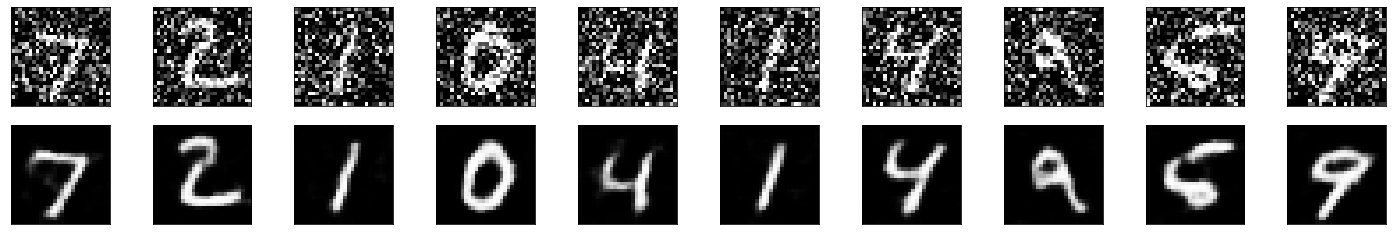

In [12]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)